# Day6 Seq2Seq - Encoder

- Sequence-to-Sequence, is a model designed to map input sequences to output sequences of potentially different lengths.

![](images/seq2seq2.png)


## Encoder Components

#### Embedding Layer
- Converts input token indices into dense, continuous vector representations.
- Allows the model to represent discrete tokens (e.g., words, characters) in a meaningful way for further processing.

#### Recurrent Neural Network (RNN)
- Processes the embeddings sequentially and captures temporal dependencies.
- Variants include:

  - Simple RNN: Basic recurrent unit.
  - LSTM (Long Short-Term Memory): Handles long-term dependencies.
  - GRU (Gated Recurrent Unit): A simplified version of LSTM.

#### Context Vector
- The final hidden state (or all hidden states) of the RNN represents the input sequence context.
- Passed to the decoder for generating output.


![](images/rnn2.png)

## Embedding Layer


- An embedding layer is used to represent discrete categorical data (like words or DNA sequences) as dense, continuous vectors.

- Dimensionality Reduction
  - Instead of representing a word or token as a large sparse vector (e.g., one-hot encoding), embeddings map them to a smaller, dense vector space.
  - One-hot vector for a vocabulary of 10,000 words: `[0, 0, ..., 1, 0]` (10,000 dimensions).
  - Embedding vector: `[0.5, -0.2, 0.1]` (e.g., 3 dimensions).

- Captures Semantic Relationships
  - Similar words or tokens are mapped to similar embeddings in the vector space.
  - "king" and "queen" might be close in embedding space, capturing semantic similarity.

- Efficient Computation
  - Dense vectors are smaller and faster to process compared to sparse representations like one-hot encoding.


![](images/embedding.png)

#### Types

- k-mer Encoding
    - Used for DNA/RNA sequences by splitting into overlapping k-length substrings.
    - Sequence: `"ACGTAC"`
    - 3-mer: `["ACG", "CGT", "GTA", "TAC"]`

- Label Encoding
    - Maps each k-mer to a unique integer.
    - Encoding: `{"ACG": 0, "CGT": 1, "GTA": 2}`


- One-Hot Encoding
  - Represents nucleotides (e.g., A, C, G, T) as binary vectors.
  - A → `[1, 0, 0, 0]`

- Embedding
  - Converts nucleotides, k-mers, or amino acids into dense vectors.
  - `A` → `[0.3, 0.7, -0.1]`

### Word2Vec

- It generates word embeddings dense vector representations of words that capture their meanings and relationships.
- Unlike traditional representations (e.g., one-hot encoding), Word2Vec places words with similar meanings closer together in a high-dimensional vector space, enabling models to understand semantic and syntactic relationships between words.

![](images/s2v2.png)

#### Data 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

num_samples = 500
num_aa_len = 10

# Define amino acids
amino_acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

# Generate synthetic amino acid sequences (random sequences)
random_corpus_amino = [[random.choice(amino_acids) for _ in range(num_aa_len)] for _ in range(num_samples)]

# Define specific amino acids to make closer
target_amino_acids = ["A", "C", "K", "I"]  # Sequence to be inserted

# Insert target_amino_acids into the middle of each sequence in random_corpus_amino
full_corpus_target_amino = []
for seq in random_corpus_amino:
    mid_index = len(seq) // 2
    new_seq = seq[:mid_index] + target_amino_acids + seq[mid_index:]
    full_corpus_target_amino.append(new_seq)

# Show shape and content of `full_corpus_target_amino`
print("Number of sequences in full_corpus_target_amino:", len(full_corpus_target_amino))
print("Example sequence (with inserted target_amino_acids):", full_corpus_target_amino[0])

Number of sequences in full_corpus_target_amino: 500
Example sequence (with inserted target_amino_acids): ['G', 'N', 'R', 'P', 'P', 'A', 'C', 'K', 'I', 'C', 'Q', 'V', 'N', 'M']


In [3]:
display(full_corpus_target_amino[0])
for idx, target in enumerate(full_corpus_target_amino[0]):
    print(f"Index {idx}: {target}")

['G', 'N', 'R', 'P', 'P', 'A', 'C', 'K', 'I', 'C', 'Q', 'V', 'N', 'M']

Index 0: G
Index 1: N
Index 2: R
Index 3: P
Index 4: P
Index 5: A
Index 6: C
Index 7: K
Index 8: I
Index 9: C
Index 10: Q
Index 11: V
Index 12: N
Index 13: M


In [4]:

# Build vocabulary
vocab_target_amino = {aa: idx for idx, aa in enumerate(set(aa for seq in full_corpus_target_amino for aa in seq))}
vocab_size_target_amino = len(vocab_target_amino)

print("Vocabulary size:", vocab_size_target_amino)

# Prepare training data (target, context) pairs
window_size = 2  # Context window size
training_data_target_amino = []
for seq in full_corpus_target_amino:
    # print("Sequence:", seq)
    for idx, target in enumerate(seq):
        context_indices = list(range(max(0, idx - window_size), min(len(seq), idx + window_size + 1)))
        # print("Context indices:", context_indices)
        if idx in context_indices:  # Prevent self-reference
            context_indices.remove(idx)
        for context_idx in context_indices:
            training_data_target_amino.append((vocab_target_amino[target], vocab_target_amino[seq[context_idx]]))
            # print("Target:", target, "Context:", seq[context_idx])
    # print("\n")
            
print("Number of training pairs:", len(training_data_target_amino))
print("Example training pair:", training_data_target_amino[:5])


Vocabulary size: 20
Number of training pairs: 25000
Example training pair: [(10, 19), (10, 8), (19, 10), (19, 8), (19, 0)]


```
Vocabulary size: 20
Sequence: ['K', 'I', 'G', 'P', 'K', 'A', 'C', 'K', 'I', 'V', 'F', 'D', 'Q', 'G']
Target: K Context: I
Target: K Context: G
Target: I Context: K
Target: I Context: G
Target: I Context: P
Target: G Context: K
Target: G Context: I
Target: G Context: P
Target: G Context: K
Target: P Context: I
Target: P Context: G
Target: P Context: K
Target: P Context: A
Target: K Context: G
Target: K Context: P
Target: K Context: A
Target: K Context: C
Target: A Context: P
Target: A Context: K
Target: A Context: C
Target: A Context: K
```

#### Training

In [5]:

# Initialize model parameters
embedding_dim = 2  # For visualization
learning_rate = 0.01
epochs = 50
W_input_target_amino = np.random.randn(vocab_size_target_amino, embedding_dim)  # Input weights
W_output_target_amino = np.random.randn(embedding_dim, vocab_size_target_amino)  # Output weights
losses_target_amino = []

# Helper functions
def one_hot_encoding(word_idx, vocab_size):
    vec = np.zeros(vocab_size)
    vec[word_idx] = 1
    return vec

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Save initial embeddings for visualization
initial_embeddings_target_amino = W_input_target_amino.copy()

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for target_idx, context_idx in training_data_target_amino:
        # Forward pass
        target_vector = one_hot_encoding(target_idx, vocab_size_target_amino)
        hidden_layer = np.dot(target_vector, W_input_target_amino)
        output_layer = np.dot(hidden_layer, W_output_target_amino)
        y_pred = softmax(output_layer)
        
        # Loss: Negative log likelihood
        loss = -np.log(y_pred[context_idx])
        total_loss += loss

        # Backpropagation
        y_true = one_hot_encoding(context_idx, vocab_size_target_amino)
        error = y_pred - y_true
        dW_output = np.outer(hidden_layer, error)
        dW_input = np.outer(target_vector, np.dot(W_output_target_amino, error.T))

        # Update weights
        W_output_target_amino -= learning_rate * dW_output
        W_input_target_amino -= learning_rate * dW_input

    losses_target_amino.append(total_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Save final embeddings after training
final_embeddings_target_amino = W_input_target_amino.copy()

Epoch 0, Loss: 72028.0166
Epoch 10, Loss: 68994.6796
Epoch 20, Loss: 68995.5950
Epoch 30, Loss: 68995.6983
Epoch 40, Loss: 68995.7019
Epoch 50, Loss: 68995.7002
Epoch 60, Loss: 68995.6995
Epoch 70, Loss: 68995.6993
Epoch 80, Loss: 68995.6993
Epoch 90, Loss: 68995.6992


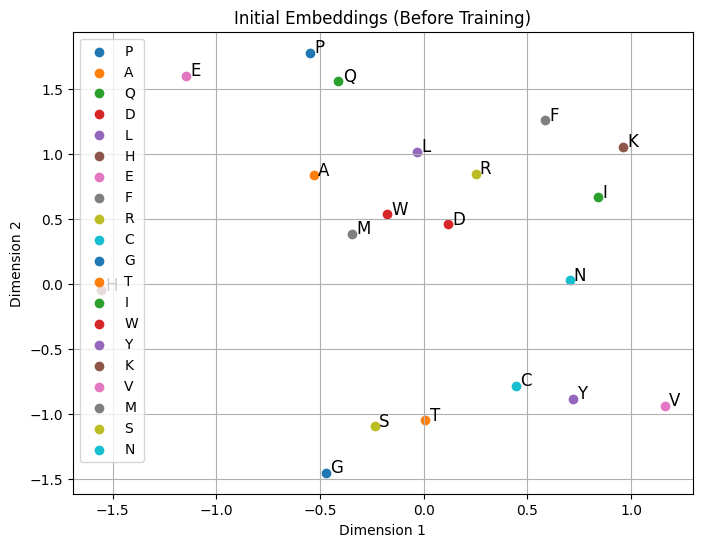

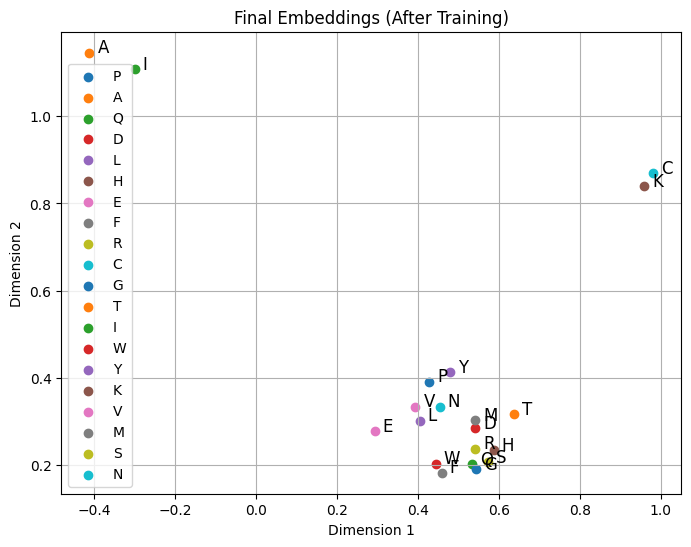

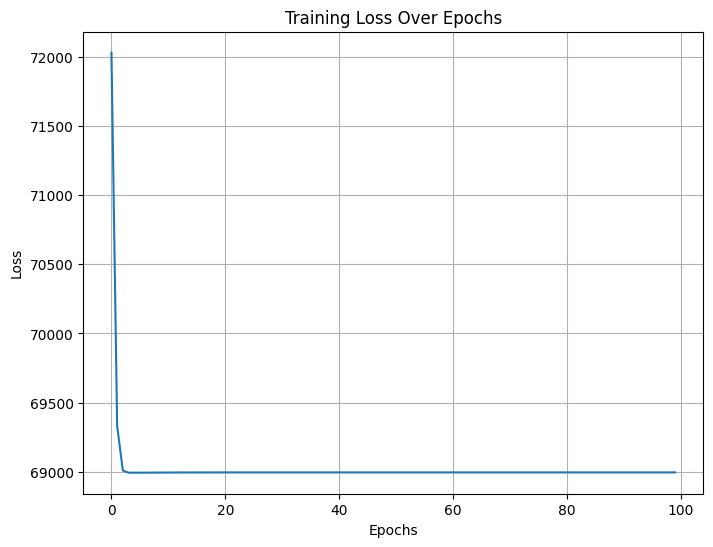

In [6]:

# Plot functions
def plot_embeddings(embeddings, title):
    plt.figure(figsize=(8, 6))
    for aa, idx in vocab_target_amino.items():
        plt.scatter(embeddings[idx, 0], embeddings[idx, 1], label=aa)
        plt.text(embeddings[idx, 0] + 0.02, embeddings[idx, 1], aa, fontsize=12)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.legend()
    plt.show()

# Plot embeddings before and after training
plot_embeddings(initial_embeddings_target_amino, "Initial Embeddings (Before Training)")
plot_embeddings(final_embeddings_target_amino, "Final Embeddings (After Training)")

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(losses_target_amino)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

### Recurrent Neural Network


- An RNN is a type of neural network designed for sequence data, where the order of inputs matters.
- Unlike feedforward networks, RNNs have a hidden state that carries information across time steps, enabling them to model dependencies in sequences.


![](images/rnn7.png)

![](images/rnn3.png)

In [34]:
import numpy as np


# Example RNN with single hidden unit
def simple_rnn_step(x, h_prev, W_x, W_h, b):
    return np.tanh(np.dot(x, W_x) + np.dot(h_prev, W_h) + b)

# Input: Sequence of 10 time step (seq len), each with 2 features (embedding dim)
emb_dim = 2
seq_len = 10
emb_sequence = np.random.randn(seq_len, emb_dim)
hidden_dim = 5
W_x = np.random.randn(emb_dim, hidden_dim)
W_h = np.random.randn(hidden_dim, hidden_dim)
b = np.random.randn(hidden_dim)

print("W_x:", W_x.shape)
# Initial hidden state
h_prev = np.zeros(hidden_dim)

# Process sequence
hidden_states = []
for x in emb_sequence:
    h_prev = simple_rnn_step(x, h_prev, W_x, W_h, b)
    hidden_states.append(h_prev)

hidden_states = np.stack(hidden_states)
print("Hidden states (NumPy):")
print(hidden_states)

W_x: (2, 5)
Hidden states (NumPy):
[[-0.98000683  0.48687102 -0.02096787  0.45009672  0.27724678]
 [-0.84668577  0.64134528 -0.82791907  0.65346347 -0.26902507]
 [-0.99263245 -0.97898747  0.41942684 -0.06326473  0.89334266]
 [-0.99449218  0.98994133 -0.75759692  0.93759738  0.99037674]
 [ 0.43438319  0.99999769 -0.99964928  0.99738487 -0.99600442]
 [-0.89626476 -0.52253602 -0.76895233  0.43461405 -0.99375944]
 [-0.06383844 -0.40320671 -0.92602607  0.99031633 -0.99885451]
 [-0.97249039 -0.99738262 -0.3035591   0.67769993 -0.41296522]
 [-0.99998021 -0.99995791  0.94914681 -0.64043451  0.99998966]
 [-0.99742254  0.56102461  0.62906189  0.39046593  0.99953853]]


![](images/rnn_dim2.png)

- $D_h$: hidden dimension
- $d$: embedding dimension

In [44]:
import torch
from torch import nn

# RNN with 4 input features and 2 hidden units
rnn = nn.RNN(input_size=2, hidden_size=5, batch_first=True)

# convert numpy array to tensor 
emb_sequence_tensor = torch.tensor(emb_sequence, dtype=torch.float32).unsqueeze(0)
print(emb_sequence_tensor.shape)

# Process sequence
output, hidden = rnn(emb_sequence_tensor)
print("Output states:")
print(output)
print(hidden)

torch.Size([1, 10, 2])
Output states:
tensor([[[ 0.2015, -0.3891, -0.2238, -0.3205,  0.1379],
         [-0.1089, -0.6302, -0.6247,  0.0182, -0.5907],
         [-0.0637, -0.6566, -0.3355, -0.2445, -0.5064],
         [ 0.3808,  0.0544, -0.1390, -0.5881, -0.0045],
         [ 0.3947, -0.0715, -0.5845, -0.1432, -0.3642],
         [ 0.1799, -0.2653, -0.3940, -0.1741, -0.1946],
         [ 0.1950, -0.0358, -0.6519, -0.0865, -0.7135],
         [ 0.2639, -0.3388, -0.4425, -0.1536, -0.5388],
         [ 0.1902, -0.5352,  0.2128, -0.5579,  0.6247],
         [ 0.0081, -0.5227, -0.2685, -0.3712,  0.4548]]],
       grad_fn=<TransposeBackward1>)
tensor([[[ 0.0081, -0.5227, -0.2685, -0.3712,  0.4548]]],
       grad_fn=<StackBackward0>)


In [36]:
import numpy as np

# Define the encoder class
class Encoder:
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Initialize weights
        self.embeddings = np.random.randn(vocab_size, embedding_dim)
        self.W_xh = np.random.randn(embedding_dim, hidden_dim)
        self.W_hh = np.random.randn(hidden_dim, hidden_dim)
        self.b_h = np.random.randn(hidden_dim)

    def forward(self, sequence):
        hidden_states = []
        h_prev = np.zeros(self.hidden_dim)  # Initial hidden state
        for idx in sequence:
            x_emb = self.embeddings[idx]  # Get the embedding for the current input
            h_t = np.tanh(np.dot(x_emb, self.W_xh) + np.dot(h_prev, self.W_hh) + self.b_h)  # Compute new hidden state
            hidden_states.append(h_t)
            h_prev = h_t  # Update the previous hidden state
        return np.array(hidden_states)


# Initialize encoder
vocab_size = len(vocab_target_amino)  # Use the vocabulary size from your data
embedding_dim = emb_sequence.shape[1]  # Use the embedding dimension from your data

encoder = Encoder(vocab_size, embedding_dim, hidden_dim)

# Encode full corpus
encoded_corpus = []
for seq in full_corpus_target_amino:
    # Convert sequence of amino acids to indices
    sequence_indices = [vocab_target_amino[aa] for aa in seq]
    # Encode the sequence
    hidden_states = encoder.forward(sequence_indices)
    encoded_corpus.append(hidden_states)

# Display the results for the first sequence
print("Encoded hidden states shape for the first sequence:", encoded_corpus[0].shape)
print("Encoded hidden states for the first sequence:")
print(encoded_corpus[0])



Encoded hidden states shape for the first sequence: (14, 5)
Encoded hidden states for the first sequence:
[[ 0.03868501  0.66606342  0.11239537  0.94252519  0.32926839]
 [-0.99970181  0.89515207  0.05415328  0.99985625 -0.97463257]
 [ 0.75058652  0.9999487  -0.97298639  0.99986108  0.5502992 ]
 [-0.79309047  0.93758224  0.77651802  0.97977334  0.68871062]
 [-0.6675474   0.66976273 -0.99566127  0.99975604 -0.99902124]
 [ 0.21431908  0.99999278 -0.22389798  0.99643739  0.75816754]
 [ 0.99707863  0.53458673 -0.9346094   0.96186194  0.8659825 ]
 [ 0.94180551 -0.1262172   0.7471511   0.76933377  0.99698075]
 [ 0.97346783 -0.94293276 -0.96551345  0.93134456  0.89477287]
 [ 0.93972524  0.03184492  0.54691498 -0.82663898  0.95346251]
 [ 0.81065257 -0.99878861  0.49700672  0.20539777  0.75313826]
 [-0.9592758  -0.93075257  0.1209835   0.81122606 -0.64387445]
 [-0.9999626   0.99963746 -0.42684594  0.99916255 -0.9996164 ]
 [ 0.7287792   0.99997848 -0.86902579  0.99966907  0.73170174]]


### Context Vector
- The final hidden state (or all hidden states) of the RNN represents the input sequence context.
- Passed to the decoder for generating output.
